# RDKit workshop

In the following, RDKit will be applied to explore a chemical dataset (Delaney) on the solubility of various substances in water (logS(mol/L)).

### Part 1: Data loading and exploration

Inspect the dataset and visualise the solubility distribution (EDA). Tasks:
- How many compounds are in the dataset?
- What is the average and range of the solubility values in the dataset?
- Are there extreme outliers (e.g. box plot)?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("delaney.csv")
df

,Compound ID,logS,SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


In [3]:
df.describe()

,logS
count,1144.000000
mean,-3.057997
std,2.096502
min,-11.600000
25%,-4.332250
50%,-2.870500
75%,-1.600000
max,1.580000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Compound ID  1144 non-null   object 
 1   logS         1144 non-null   float64
 2   SMILES       1144 non-null   object 
dtypes: float64(1), object(2)
memory usage: 26.9+ KB


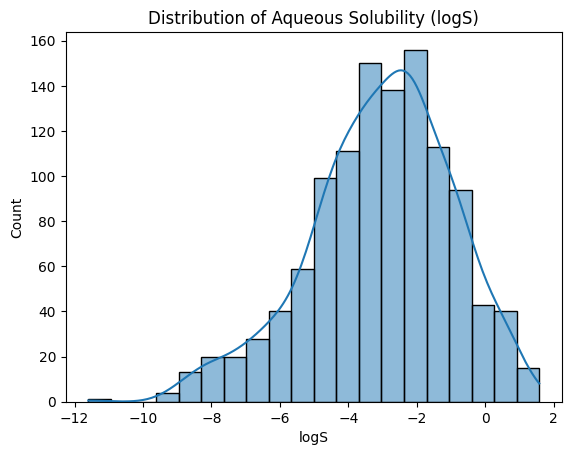

In [5]:

sns.histplot(df['logS'], bins=20, kde=True)
plt.title("Distribution of Aqueous Solubility (logS)")
plt.show()

<Axes: >

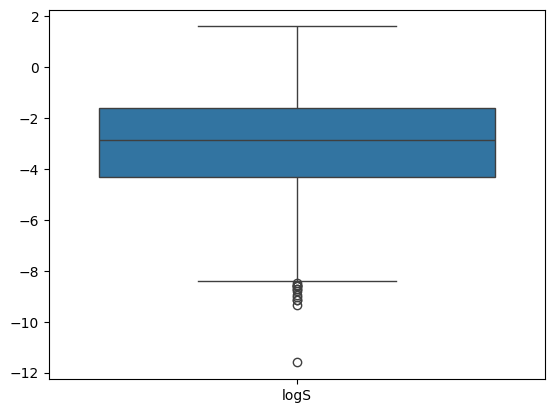

In [4]:
sns.boxplot(df)

### Part 2: Compute descriptors with RDKit

Calculate molecular descriptors from the SMILES. See snippet below for the syntax of doing so.

Tasks:
- Compute 5-10 descriptors based on the SMILES (e.g. use the apply() method in pandas) and add them to the DataFrame
- Find out if there is any correlation of the descriptors and the solubility (e.g. plots)

Some info on available descriptors: 
- https://github.com/hypowergravity/RDKitDescriptorExamples-
- https://schwallergroup.github.io/practical-programming-in-chemistry/tutorials/lecture_05/02_rdkit_descriptors.html
- https://deepwiki.com/rdkit/rdkit/6.1-chemical-reactions#molecular-descriptors-and-properties

In [5]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Syntax for deriving descriptors:
# 1) convert smiles to Mol: mol = Chem.MolFromSmiles(smiles)
# 2) derive descriptor, e.g. for MolWt: descr = Descriptors.MolWt(mol)

descr_list = ["MolWt", "MolLogP", "TPSA", "NumHDonors", "NumHAcceptors","NumHeteroatoms", "HeavyAtomCount", "NOCount" ]

def calc_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)

# for descr in descr_list:
#     df[descr] = df["SMILES"].apply(lambda s: calc_descriptors(s, descr))

df["MolWt"] = df["SMILES"].apply(lambda s: Descriptors.MolWt(Chem.MolFromSmiles(s)))
df["MolLogP"] = df["SMILES"].apply(lambda s: Descriptors.MolLogP(Chem.MolFromSmiles(s)))
df["NumHeteroatoms"] = df["SMILES"].apply(lambda s: Descriptors.NumHeteroatoms(Chem.MolFromSmiles(s)))
df["SPS"] = df["SMILES"].apply(lambda s: Descriptors.SPS(Chem.MolFromSmiles(s)))
df["Phi"] = df["SMILES"].apply(lambda s: Descriptors.Phi(Chem.MolFromSmiles(s)))
df.head()

,Compound ID,logS,SMILES,MolWt,MolLogP,NumHeteroatoms,SPS,Phi
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,4,12.00,2.939419
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,3,12.00,1.814285
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,4,11.00,3.817823
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,3,9.60,3.610448
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,6,14.25,2.294762


In [6]:
df.describe()

,logS,MolWt,MolLogP,NumHeteroatoms,SPS,Phi
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,-3.057997,204.631675,2.449133,3.378497,14.679241,3.505139
std,2.096502,102.620500,1.866003,2.805305,11.111498,2.361926
min,-11.600000,16.043000,-7.571400,0.000000,0.000000,0.000000
25%,-4.332250,122.126000,1.414900,1.000000,9.412500,1.901825
50%,-2.870500,183.594500,2.340300,3.000000,10.558442,2.958543
75%,-1.600000,270.715750,3.406475,5.000000,13.913636,4.424487
max,1.580000,780.949000,10.388600,16.000000,80.952381,25.000000


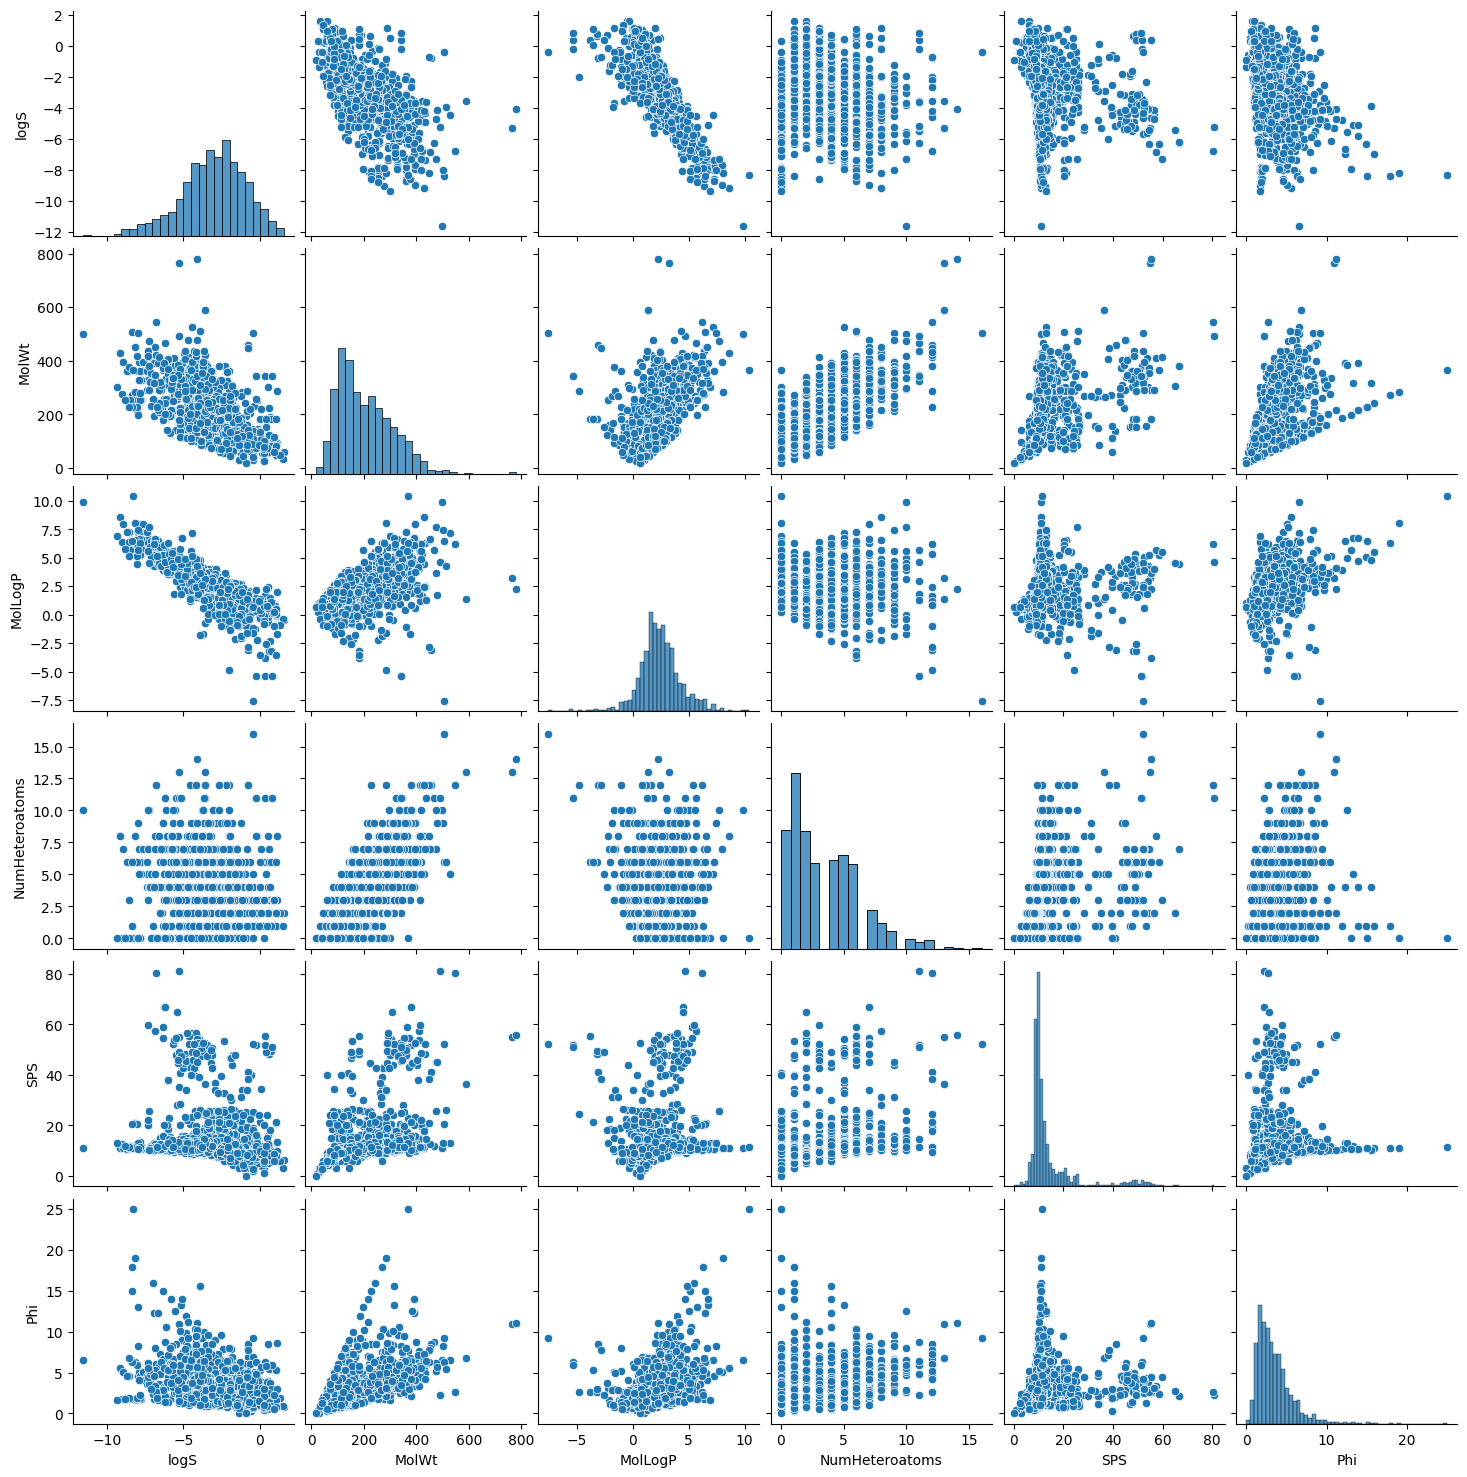

In [7]:
sns.pairplot(df)
plt.show()

### Part 3: Predict solubility (Regression Model)

Use the code below to predict the logS using a RandomForestRegressor:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = df.drop(columns=["logS", "Compound ID", "SMILES"], axis=1)
y = df["logS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)

print("R²:", r2_score(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("train accuracy:", model.score(X_train, y_train))
print("test accuracy:", model.score(X_test, y_test))


R²: 0.8868655406358614
RMSE: 0.7018894609014265
train accuracy: 0.981937808730429
test accuracy: 0.8868655406358614


Based on the EDA, which descriptors might influence the solubility the most?

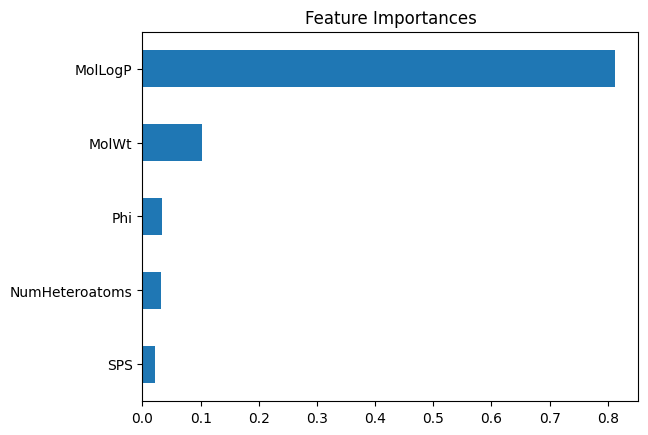

In [14]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()

### Part 4: Similarity Search

Create fingerprints from the SMILES and add them to the dataframe.

In [18]:
from rdkit.Chem import rdFingerprintGenerator, DataStructs

# use e.g. the morgan FPG: mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
def mol2fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
    fp = mfpgen.GetFingerprint(mol)
    return fp

df["fingerprint"] = df["SMILES"].apply(mol2fp)
smiles_list = df["SMILES"].to_list()
smiles_list

['ClCC(Cl)(Cl)Cl',
 'CC(Cl)(Cl)Cl',
 'ClC(Cl)C(Cl)Cl',
 'ClCC(Cl)Cl',
 'FC(F)(Cl)C(F)(Cl)Cl',
 'CC(Cl)Cl',
 'ClC(=C)Cl',
 'CCOC(C)OCC',
 'Clc1ccc(Cl)c(Cl)c1Cl',
 'C1CCc2ccccc2C1',
 'Clc1cc(Cl)c(Cl)c(Cl)c1',
 'Clc1cccc(Cl)c1Cl',
 'Cc1cccc(C)c1C',
 'Brc1cc(Br)c(Br)cc1Br',
 'Clc1cc(Cl)c(Cl)cc1Cl',
 'Cc1cc(C)c(C)cc1C',
 'c1(Br)c(Br)cc(Br)cc1',
 'Clc1ccc(Cl)c(Cl)c1',
 'Cc1ccc(C)c(C)c1',
 'Oc1ccccc1O',
 'Brc1ccccc1Br',
 'BrCCBr',
 'Clc1ccccc1Cl',
 'ClCCCl',
 'CC(Cl)CCl',
 'FC(F)(Cl)C(F)(F)Cl',
 'CCOCCOCC',
 'CCc1ccccc1CC',
 'O=N(=O)c1ccccc1N(=O)=O',
 'CC1CO1',
 'Brc1cc(Br)cc(Br)c1',
 'Clc1cc(Cl)cc(Cl)c1',
 'Cc1cc(C)cc(C)c1',
 'O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O',
 'Oc1cccc(O)c1',
 'C=CC=C',
 'Brc1cccc(Br)c1',
 'Clc1cccc(Cl)c1',
 'ClCCCCl',
 'CCNC(=S)NCC',
 'Fc1cccc(F)c1',
 'Cc1cc(C)c2ccccc2c1',
 'O=N(=O)c1cccc(c1)N(=O)=O',
 'Oc1ccc(O)cc1',
 'C1C=CCC=C1',
 'Brc1ccc(Br)cc1',
 'Clc1ccc(Cl)cc1',
 'CCc1ccc(CC)cc1',
 'Fc1ccc(F)cc1',
 'Cc1ccc(C)c2ccccc12',
 'O=N(=O)c1ccc(cc1)N(=O)=O',
 'C=CCC=C',
 '

In [16]:
df

,Compound ID,logS,SMILES,MolWt,MolLogP,NumHeteroatoms,SPS,Phi,fingerprint
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl,167.850,2.59540,4,12.000000,2.939419,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl,133.405,2.37650,3,12.000000,1.814285,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl,167.850,2.59380,4,11.000000,3.817823,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl,133.405,2.02890,3,9.600000,3.610448,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.91890,6,14.250000,2.294762,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC),287.343,1.98820,8,13.500000,8.584811,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,286.114,3.42130,6,23.166667,3.086160,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,308.333,3.60960,4,12.217391,3.977030,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,354.815,2.56214,8,11.304348,4.648177,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Calculate the Tanimoto similarity of the molecules in the dataframe in comparison to a molecule of your choice (e.g. caffeine, aniline, ethanol).

In [27]:
query_fp = mol2fp("Nc1ccccc1")
print(query_fp)

df["similarity"] = df["fingerprint"].apply(lambda fp: DataStructs.TanimotoSimilarity(fp, query_fp))
df

,Compound ID,logS,SMILES,MolWt,MolLogP,NumHeteroatoms,SPS,Phi,fingerprint,similarity
0,"1,1,1,2-Tetrachloroethane",-2.180,ClCC(Cl)(Cl)Cl,167.850,2.59540,4,12.000000,2.939419,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
1,"1,1,1-Trichloroethane",-2.000,CC(Cl)(Cl)Cl,133.405,2.37650,3,12.000000,1.814285,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
2,"1,1,2,2-Tetrachloroethane",-1.740,ClC(Cl)C(Cl)Cl,167.850,2.59380,4,11.000000,3.817823,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
3,"1,1,2-Trichloroethane",-1.480,ClCC(Cl)Cl,133.405,2.02890,3,9.600000,3.610448,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
4,"1,1,2-Trichlorotrifluoroethane",-3.040,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.91890,6,14.250000,2.294762,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
...,...,...,...,...,...,...,...,...,...,...
1139,vamidothion,1.144,CNC(=O)C(C)SCCSP(=O)(OC)(OC),287.343,1.98820,8,13.500000,8.584811,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000000
1140,Vinclozolin,-4.925,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,286.114,3.42130,6,23.166667,3.086160,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.048780
1141,Warfarin,-3.893,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,308.333,3.60960,4,12.217391,3.977030,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.142857
1142,Xipamide,-3.790,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,354.815,2.56214,8,11.304348,4.648177,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.111111


In [28]:
df["similarity"].nlargest(10)

394     1.000000
910     0.466667
916     0.466667
440     0.428571
913     0.411765
920     0.411765
970     0.411765
783     0.400000
844     0.400000
1006    0.400000
Name: similarity, dtype: float64

### Part 5: Clustering molecules by strucutre

Use fingerprints to group molecules into clusters (using k-means clustering) and visualise via PCA. Tasks:
- Experiment with different numbers of clusters
- Compute the average solubility per cluster
- Do certain clusters correspond to highly or poorly soluble compounds?

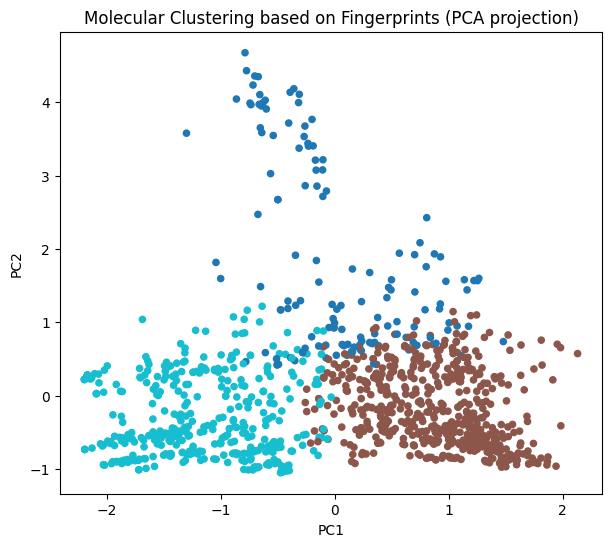

In [30]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

fps = df["fingerprint"].to_list()

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(fps)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(fps)
df["cluster"] = clusters

# Visualize clusters
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="tab10", s=20)
plt.title("Molecular Clustering based on Fingerprints (PCA projection)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

In [31]:
print(df.groupby("cluster")["logS"].mean())

cluster
0   -4.041540
1   -3.574464
2   -2.094190
Name: logS, dtype: float64


In [32]:
df["has_aromat"] = df["SMILES"].apply(lambda s: Chem.MolFromSmiles(s).HasSubstructMatch(Chem.MolFromSmarts("a")))
pd.crosstab(df["cluster"], df["has_aromat"])

has_aromat,False,True
cluster,,
0,52,87
1,12,550
2,405,38


### Part 6: Substructure Search via SMARTS

Search for specific functional groups or chemical motifs within the dataset using SMARTS (SMiles ARbitrary Target Specification): e.g. alcohol = "[OX2H]", carboxylic acid = "C(=O)[OH]", aromatic compounds = "a", amines = "[NX3;H2,H1;!$(NC=O)]"

See here for a more detailed list of SMARTS: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html 

Tasks:
- Count how many molecules contain each functional group (method: Mol.HasSubstructMatch(SMARTS)).
- Compare average solubility for molecules with vs. without each substructure.
- Visualize with a bar plot.

In [36]:
from rdkit import Chem

patterns = {
    "Hydroxyl": Chem.MolFromSmarts("[OX2H]"),
    "Carboxylic acid": Chem.MolFromSmarts("C(=O)[OH]")
}

def has_substructure(smiles, patt):
    mol = Chem.MolFromSmiles(smiles)
    return mol.HasSubstructMatch(patt)

for name, patt in patterns.items():
    df[name] = df["SMILES"].apply(lambda s: has_substructure(s, patt))

df.head()


,Compound ID,logS,SMILES,MolWt,MolLogP,NumHeteroatoms,SPS,Phi,fingerprint,similarity,cluster,has_aromat,Hydroxyl,Carboxylic acid
0,"1,1,1,2-Tetrachloroethane",-2.18,ClCC(Cl)(Cl)Cl,167.850,2.5954,4,12.00,2.939419,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False
1,"1,1,1-Trichloroethane",-2.00,CC(Cl)(Cl)Cl,133.405,2.3765,3,12.00,1.814285,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False
2,"1,1,2,2-Tetrachloroethane",-1.74,ClC(Cl)C(Cl)Cl,167.850,2.5938,4,11.00,3.817823,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False
3,"1,1,2-Trichloroethane",-1.48,ClCC(Cl)Cl,133.405,2.0289,3,9.60,3.610448,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False
4,"1,1,2-Trichlorotrifluoroethane",-3.04,FC(F)(Cl)C(F)(Cl)Cl,187.375,2.9189,6,14.25,2.294762,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,2,False,False,False


In [37]:
df[list(patterns.keys())].sum()

Hydroxyl           245
Carboxylic acid      0
dtype: int64

In [38]:
for name in patterns.keys():
    print(df.groupby(name)["logS"].mean())

Hydroxyl
False   -3.262195
True    -2.308718
Name: logS, dtype: float64
Carboxylic acid
False   -3.057997
Name: logS, dtype: float64


No Carboxylic acid in dataset


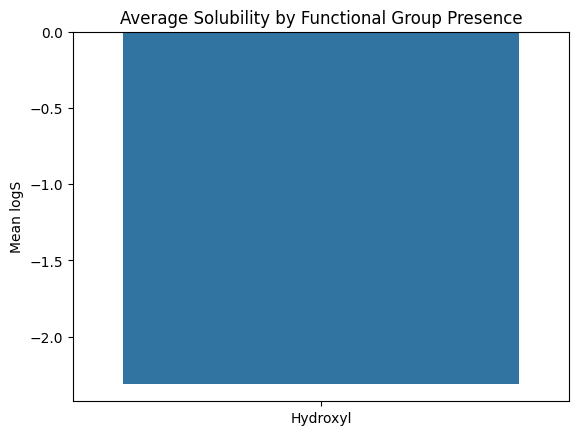

In [39]:
import seaborn as sns
means = {}

for name in patterns.keys():
    mean_series = df.groupby(name)["logS"].mean()
    if len(mean_series) > 1:
        val = mean_series.iloc[1]
        means[name] = val
    else:
        print(f"No {name} in dataset")

sns.barplot(x=list(means.keys()), y=list(means.values()))
plt.title("Average Solubility by Functional Group Presence")
plt.ylabel("Mean logS")
plt.show()